# Pryngles module: scatterer

## External modules

In [1]:
#@external
from pryngles import *

from abc import ABC, abstractmethod
from scipy.optimize import bisect
from scipy.integrate import quad,dblquad
from scipy.interpolate import interp1d,interp2d
#@end

## Scatterer Class Interface

### Docstring

In [2]:
#@docstring:Scatterer
Scatterer_doc="""An scatterer surface

Initialization attributes:

    phase_law: function, default=lambda eta,zeta,delta,lambda:eta :

        Law of reflection (by default is Lambertian, see Russel, 1916)

        The phase_law must obey the following prototype:

            phase_law(eta,zeta,delta,lamb,**params):
                '''Phase law of the surface

                Parameters:
                    eta: float:
                        cosine of the incoming angle.

                    zeta: float:
                        cosine of the outgoing angle.

                    delta: float:
                        difference between the incoming and outgoing azimuth.

                    lamb: float:
                        Wavelength.

                    parameters: dictionary: 
                        Other parameters of the phase law.

                Return:
                    Wavelength dependent albedo.
                '''
                ...

            Other law is the Lommel-Seeliger law:

                phase_law = lambda eta,zeta,delta,params:eta*zeta/(eta+zeta) (see Russel, 1916)

     params: dictionary:
         Other parameters of the phase law.
         
Mandatory methods:

    __init__(self,phase_law:lambda,**params)
    get_albedo(eta:float,zeta:float,delta:float,lamb:float,**params)->float
    
Class methods:
    show
    
Usage:
    You can create a Scatterer which implements this class:
    
        class MySurface(Scatterer):
            def __init__(self,phase_law,**params):
                self.A=params["A"]
        
            deg get_albedo(eta,zeta,delta,lamb,**params):
                albedo=self.A*eta
                return albedo
"""
#@end:docstring

In [3]:
#@class
class Scatterer(PrynglesCommon,ABC):
    
    @abstractmethod
    def __init__(self,
                 phase_law=lambda eta,zeta,delta,lamb,params:eta,
                 **params):
        pass
    
    @abstractmethod
    def get_albedo(self,eta:float,zeta:float,delta:float,lamb:float,**params)->float:
        pass
    
    @classmethod
    def show(self):
        print(self.__dict__)
        
#@end:class

In [4]:
#@test:template
def test_interface(self):
    
    Verbose.VERBOSITY=VERB_NONE
    
    class MySurface(Scatterer):
        def __init__(self,phase_law,**params):
            self.A=params["A"]

        def get_albedo(self,eta,zeta,delta,lamb,**params):
            albedo=self.A*eta
            return albedo
        
    S=MySurface(None,A=0.5)
    print(S.get_albedo(0.5,0,0,0))
    
    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_interface=test_interface
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

.

0.25



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


## Specific Scatterer Interfaces

### Neutral surface

In [36]:
#@class
class NeutralSurface(Scatterer):
    """Neutral surface.
    """
    
    def __init__(self,
                 phase_law=lambda eta,zeta,delta,lamb,params:eta,
                 **params):
        pass
    
    def get_albedo(self,eta,zeta,delta,lamb,**params):
        return 1
#@end:class

#@class
class BlackBodySurface(Scatterer):
    """Neutral surface.
    """
    
    def __init__(self,
                 phase_law=lambda eta,zeta,delta,lamb,params:eta,
                 **params):
        pass
    
    def get_albedo(self,eta,zeta,delta,lamb,**params):
        return 0
#@end:class

### Lambertian gray suface

In [5]:
#@class
class LambertianGraySurface(Scatterer):
    """Lambertian Gray Surface.
    
    This is the scatterer corresponding to a surface having a gray lambertian Albedo.
    """
    
    def __init__(self,
                 phase_law=lambda eta,zeta,delta,lamb,params:eta,
                 **params):

        
        self.phase_law=phase_law
        
        #Gray albedo
        self.AL=params["AL"]
        
        #Calculate the gammap parameter
        self.gammap0=self._find_gammap()
        
        #Accelerate the calculation of the albedo
        self._accelerate_lambertian_albedo()

    def get_albedo(self,eta,zeta,delta,lamb,**params):
        return self._get_albedo(eta)
        
    #####################################
    #Complimentary routines
    #####################################
    def _calc_lambertian_albedo(self,eta,gammap0=1):
        if eta==0:return self.AL
        integrand=lambda zeta:self.phase_law(eta,zeta,0,0,0)/eta
        AL=2*np.pi*gammap0*quad(integrand,0,1)[0]
        return AL

    def _find_gammap(self):
        function=lambda gammap0:self._calc_lambertian_albedo(1,gammap0)-self.AL
        gammap0=bisect(function,0.0,1.0,rtol=1e-3)
        return gammap0 if gammap0<=1 else 1
    
    def _accelerate_lambertian_albedo(self):
        etas=np.linspace(0.0,1.0,20)
        ALs=np.array([self._calc_lambertian_albedo(eta,gammap0=self.gammap0) for eta in etas])
        self._get_albedo=interp1d(etas,ALs)

#@end:class

<IPython.core.display.Javascript object>


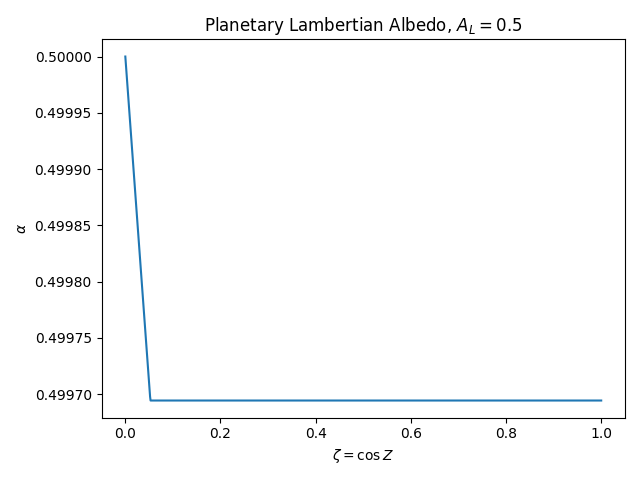

.
----------------------------------------------------------------------
Ran 1 test in 0.172s

OK


In [6]:
#@test:template
def test_lambsurface(self):
    
    global LA
    
    Verbose.VERBOSITY=VERB_NONE
    
    LA=LambertianGraySurface(AL=0.5)
    etas=np.linspace(0,1,1000)
    fig,axs=plt.subplots(1,1)

    ax=axs
    ax.plot(etas,LA.get_albedo(etas,0,0,0))
    ax.set_xlabel(r"$\zeta = \cos Z$")
    ax.set_ylabel(r"$\alpha$")
    ax.set_title(rf"Planetary Lambertian Albedo, $A_L=${LA.AL}");

    fig.tight_layout()
    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_lambsurface=test_lambsurface
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### Lambertian gray atmosphere

In [7]:
#@class
class LambertianGrayAtmosphere(Scatterer):
    """Lambertian Gray Atmopshere.
    
    This is the scatterer corresponding to plane-parallel gray lambertian atmosphere
    """
    
    def __init__(self,
                 phase_law=lambda eta,zeta,delta,lamb,params:eta,
                 **params):

        
        self.phase_law=phase_law
        
        #Gray albedo
        self.AS=params["AS"]
        
        #Load reflection functions
        self._load_reflection_functions()
        
        #Calculate the gammap parameter
        self.gamma0=self._find_gamma()
        
        #Accelerate the calculation of the albedo
        self._accelerate_lambertian_albedo()

    def get_albedo(self,eta,zeta,delta,lamb,**params):
        return self._get_albedo(eta)
        
    #####################################
    #Complimentary routines
    #####################################
    def _load_reflection_functions(self):
        """Load value of reflection fucntions.

        Update:
            fint: 2d interpolating function:
                x: eta (cosine incident angle)
                y: zeta (cosine scattering angle)

        Notes:
            Tab. (2.3) in Sobolev (1975).
        """
        data_ss=np.loadtxt(Misc.get_data("diffuse_reflection_function.data"))
        eta=data_ss[1:,0]
        gamma=data_ss[0,1:]
        f=data_ss[1:,1:]
        self.fint=interp2d(gamma,eta,f)  

    def _calc_reflection_coefficient(self,eta,zeta,gamma0=1):
        """Reflection coefficient of a semi-infinite (tau = infinity) atmosphere with (gray) 
        single scattering albedo gamma0

        Requires:
            - _loadReflectionFunctions

        Notes:
            Ec. (2.43) in Sobolev (1975).
        """
        rho0=gamma0*self.fint(gamma0,eta)[0]*self.fint(gamma0,zeta)[0]/(4*(eta+zeta))
        return rho0

    def _calc_spherical_albedo(self,gamma0):
        """
        Compute spherical albedo from single scattering albedo for a semi-infinite atmosphere.

        Parameters:
            gamma0: single scattering albedo (0<=gamma0<=1), float.

        Returns:
            AS: ratio of the energy diffusely reflected by a spherical planet (0<=AS<=1), float.

        Requires:
            - _loadReflectionFunctions

        Notes:
            Ec. (1.87) in Sobolev (1975).    
        """

        AS=4*dblquad(lambda y,x,*args:self._calc_reflection_coefficient(x,y,*args)*x*y,
                     0,1,lambda x:0,lambda x:1,epsrel=1e-2,args=(gamma0,))[0]
        return AS

    def _find_gamma(self):
        """
        Starting with a target spherical albedo AS, find the value of the single scattering albedo gamma0
        of a semi-infinite atmosphere having that Albedo.

        Returns:
            gamma0: the value of gamma0 corresponding to AS (0<=gamma0<=1), float.
        """
        if np.isclose(self.AS,1,rtol=1e-2):
            return 1
        function=lambda gamma0:self._calc_spherical_albedo(gamma0)-self.AS
        gamma0=bisect(function,0.0,1.0,rtol=1e-4)
        return gamma0 if gamma0<=1 else 1

    def _calc_lambertian_albedo(self,eta):
        """
        Notes: 
            Yanovistkii (1973)
        """
        integrand=lambda zeta:self._calc_reflection_coefficient(eta,zeta,gamma0=self.gamma0)*zeta
        AL=2*quad(integrand,0,1,epsrel=1e-3)[0]
        return AL

    def _accelerate_lambertian_albedo(self):
        etas=np.linspace(0,1,20)
        ALs=np.array([self._calc_lambertian_albedo(eta) for eta in etas])
        self._get_albedo=interp1d(etas,ALs)

#@end:class

<IPython.core.display.Javascript object>


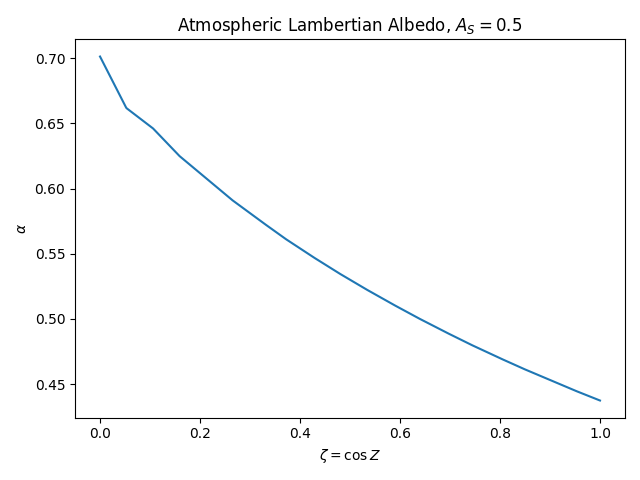

.
----------------------------------------------------------------------
Ran 1 test in 0.308s

OK


In [8]:
#@test:template
def test_lambatmos(self):
    
    global LA
    
    Verbose.VERBOSITY=VERB_NONE
    
    LA=LambertianGrayAtmosphere(AS=0.5)
    etas=np.linspace(0,1,1000)
    fig,axs=plt.subplots(1,1)

    ax=axs
    ax.plot(etas,LA.get_albedo(etas,0,0,0))
    ax.set_xlabel(r"$\zeta = \cos Z$")
    ax.set_ylabel(r"$\alpha$")
    ax.set_title(rf"Atmospheric Lambertian Albedo, $A_S=${LA.AS}");

    fig.tight_layout()
    Verbose.VERBOSITY=VERB_NONE


class Test(unittest.TestCase):pass
Test.test_lambatmos=test_lambatmos
unittest.main(argv=['first-arg-is-ignored'],exit=False)
#@end:test

### The end

In [9]:
#@end:module

## Playing ground

Let's create an identical system

Create system:

In [10]:
sys=System()
S=sys.add(kind="Star",radius=Consts.rsun/sys.ul,limb_coeffs=[0.65])
P=sys.add(kind="Planet",parent=S,a=0.2,e=0.0,radius=Consts.rsaturn/sys.ul)
R=sys.add(kind="Ring",parent=P,fi=1.5,fe=2.5,i=30*Consts.deg,roll=-90*Consts.deg)
sys.initialize_simulation()
sys.spangle_system()
RP=sys.ensamble_system(lamb=90*Consts.deg,beta=90*Consts.deg,AL=0.5,AS=0.5)

<IPython.core.display.Javascript object>


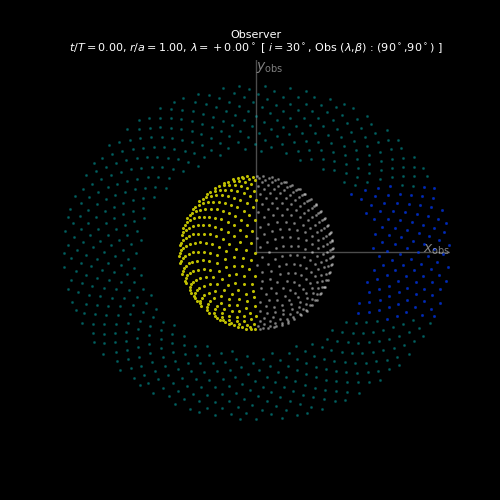

In [11]:
RP._plot["fs"]=5
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


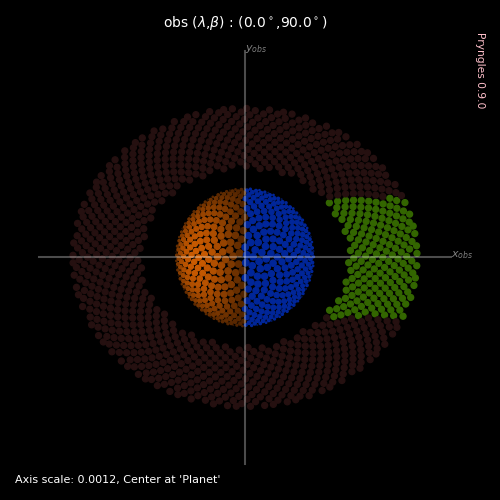

(0.18181818566061467, -6.003593414911354e-09)

In [12]:
sys.sg.plot2d(include=[P,R])

Number of spangles:

In [13]:
RP.Np,RP.Nr

(1000, 652)

In [14]:
P.sg.nspangles,R.sg.nspangles,(sys.data.name=="Planet").sum(),((sys.data.name=="Ring")&(~sys.data.hidden)).sum()

(987, 1064, 987, 1039)

Compared properties

In [15]:
RP.Rplanet,RP.Rstar,RP.Rp,RP.Rs,RP.Ri,RP.Re

(0.00040286669668487465,
 0.004650467260962157,
 0.08662929423602127,
 1.0,
 0.1299439413540319,
 0.21657323559005318)

In [16]:
sys.bodies["Planet"].radius,sys.bodies["Planet"].radius,\
sys.bodies["Planet"].radius/sys.bodies["Star"].radius,\
sys.bodies["Ring"].ri/sys.bodies["Star"].radius,sys.bodies["Ring"].re/sys.bodies["Star"].radius,

(0.00040286669668487465,
 0.00040286669668487465,
 0.08662929423602127,
 0.1299439413540319,
 0.21657323559005318)

Change stellar position:

<IPython.core.display.Javascript object>


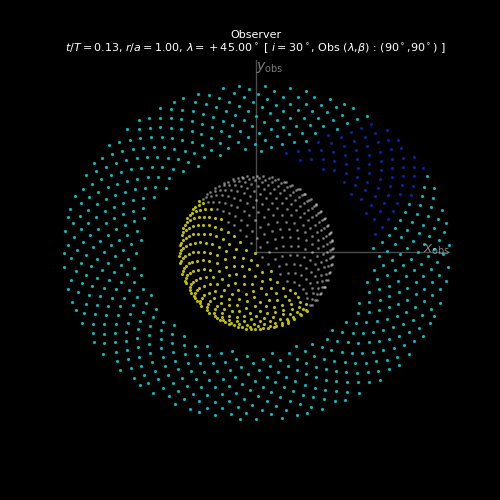

In [17]:
RP.changeStellarPosition(45*Consts.deg)
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


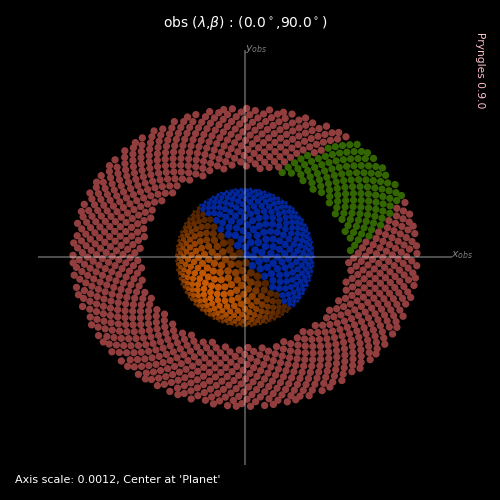

(0.1285648731490779, 0.12856486330305156)

In [18]:
sys.integrate(sys.sim.particles[1].P/8)
sys.update_perspective()
sys.sg.plot2d(include=[P,R])

<IPython.core.display.Javascript object>


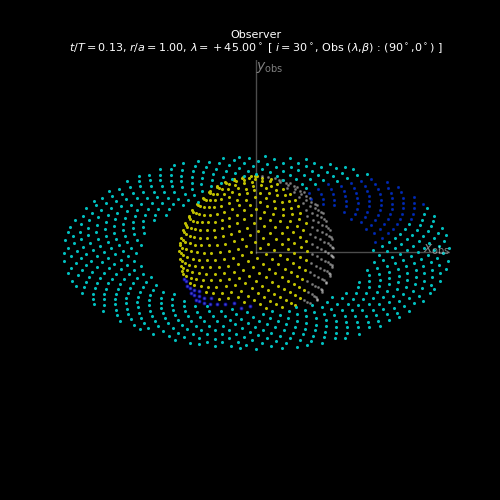

In [19]:
RP.changeObserver([90.0*Consts.deg,0.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


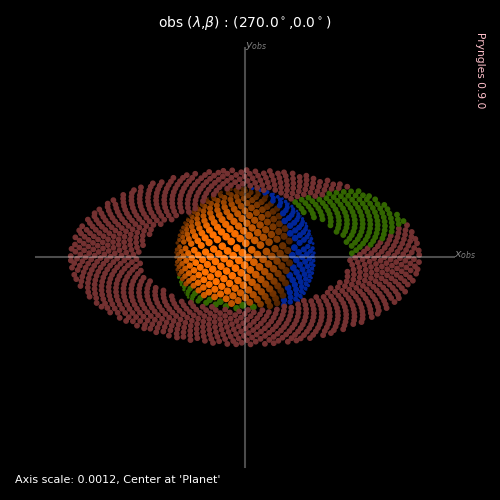

(0.1285648731490779, -8.861434635287762e-07)

In [20]:
sys.update_perspective(n_obs=Science.direction(-90,0))
sys.sg.plot2d(include=[P,R])

## Flux calculation

<IPython.core.display.Javascript object>


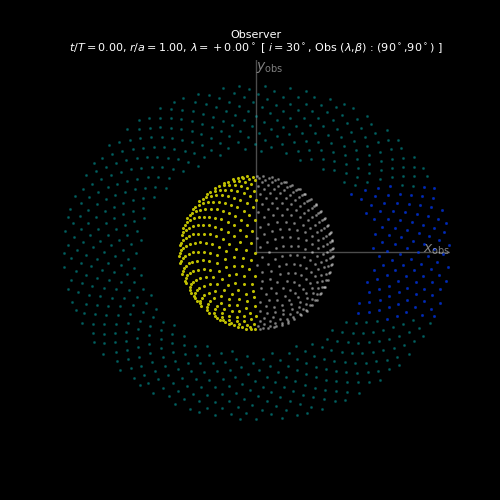

In [21]:
RP.changeStellarPosition(0.0*DEG)
RP.changeObserver([90.0*Consts.deg,90.0*Consts.deg])
ecl,obs,star=RP.plotRingedPlanet(showfig=0)
obs

<IPython.core.display.Javascript object>


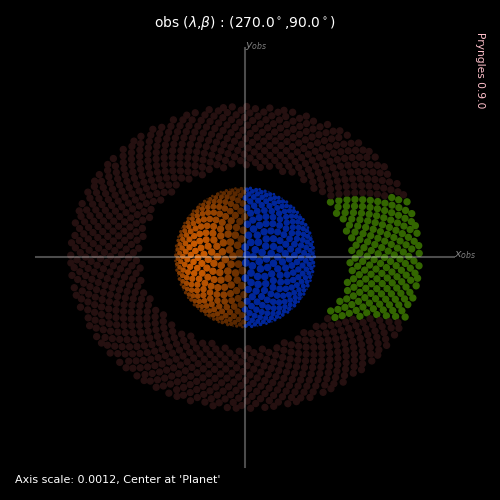

(0.18181818566061467, -6.003593434123292e-09)

In [22]:
sys.integrate(sys.sim.particles[1].P/12*0)
sys.update_perspective(n_obs=Science.direction(-90,90))
sys.sg.plot2d(include=[P,R])

In all calculations in the `RingedPlanet` interface the length units are stellar radii.

Now calculate flux from the planet:

In [23]:
RP.updateDiffuseReflection()
Flux_calculated=RP.Rip.sum()
Flux_calculated

1.1111755317854611e-07

The total expected flux without taking into account the law of reflection:

In [24]:
Flux_expected_tradition=(RP.Ap/2)/(4*np.pi*RP.rstar**2)
Flux_expected_tradition

5.071924228055711e-07

The flux reflected taking into account the law of reflection:

In [25]:
Flux_expected_real=(2*RP.Rp**2/3)/(4*np.pi*RP.rstar**2)*0.5
Flux_expected_real

1.0762957491768159e-07

Difference is due to the fact that Albedo is not exactly 0.5.

### System interface: areas

Area of the planet:

In [26]:
4*np.pi*P.radius**2

2.03954174648626e-06

Area computed from spangles:

In [27]:
cond=(sys.data.name=="Planet")
sys.data[cond].asp.sum()

2.0395417464862597e-06

If we use the areas from the light and observer point of view the value is slightly different due to discretization errors:

In [28]:
sys.data[cond].asp_obs.sum(),sys.data[cond].asp_luz.sum()

(2.035160338173772e-06, 2.0457642814974437e-06)

Area of the planet from above:

In [29]:
cond=(sys.data.name=="Planet")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

5.098854366215656e-07

In [30]:
cond=(sys.data.name=="Planet")&(sys.data.illuminated)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

5.098854366215648e-07

Actual transversal area:

In [31]:
np.pi*P.radius**2

5.09885436621565e-07

Area of the ring from above:

In [32]:
cond=(sys.data.name=="Ring")&(sys.data.visible)
(sys.data[cond].asp_obs*sys.data[cond].cos_obs).sum()

1.766294964535963e-06

In [33]:
cond=(sys.data.name=="Ring")&(sys.data.illuminated)&(~sys.data.hidden)
(sys.data[cond].asp_luz*sys.data[cond].cos_luz).sum()

-8.656742894061219e-23

Theoretical area of the ring:

In [34]:
np.pi*(R.re**2-R.ri**2)*np.cos(30*Const.deg)

1.7662949645359824e-06

### System interface: fluxes

<IPython.core.display.Javascript object>


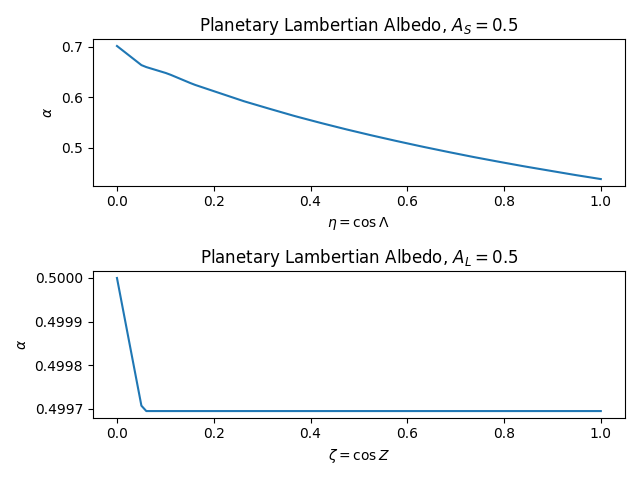

In [152]:
etas=np.linspace(0,1,100)
fig,axs=plt.subplots(2,1)

ax=axs[0]
ax.plot(etas,RP.getLambertianAlbedoPlanet(etas))
ax.set_xlabel(r"$\eta = \cos\Lambda$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_S=${RP.AS}");

ax=axs[1]
ax.plot(etas,RP.getLambertianAlbedoRing(etas))
ax.set_xlabel(r"$\zeta = \cos Z$")
ax.set_ylabel(r"$\alpha$")
ax.set_title(rf"Planetary Lambertian Albedo, $A_L=${RP.AL}");

fig.tight_layout()